In [1]:
import torch
import copy
import os
from torch import nn
from torch.utils.tensorboard import SummaryWriter
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from itertools import product
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

random_state = 42
np.random.seed(random_state)

plt.style.use("seaborn-v0_8")

###################### le teniamo?
# if not os.path.exists('results'):
#     os.mkdir('results')

# if not os.path.exists('results/pca'):
#     os.mkdir('results/pca')

# if not os.path.exists('results/no_pca'):
#     os.mkdir('results/no_pca')

## Neural Network ML

In [16]:
################## ???
# is_pca = True

# if is_pca:
#     path = 'runs/nn/nn_pca/'
#     results_path = 'results/pca/'
# else:
#     path = 'runs/nn/nn_no_pca/'
#     results_path = 'results/no_pca/'

In [2]:
df = pd.read_csv("train.csv")
num_rows, num_cols = df.shape
print("Rows: ", num_rows)
print("Columns: ", num_cols)

Rows:  252175
Columns:  91


In [3]:
print("Null rows:", df.shape[0] - df.dropna().shape[0])
print("Duplicated rows:", df.duplicated().sum())
df.drop_duplicates(inplace=True)

Null rows: 0
Duplicated rows: 52


In [4]:
# PyTorch Device
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)

print("Using {} device".format(device))

Using cpu device


### Data Preprocessing

In [19]:
from sklearn.model_selection import train_test_split

df_X = df.iloc[:, 1:]
df_y = df.iloc[:, 0]
X_train, X_test, y_train, y_test = train_test_split(df_X, df_y, test_size=0.3, random_state=random_state)
print("Train length: {}\nTest length: {}".format(X_train.shape[0], X_test.shape[0]))

# Convert to numpy arrays
X_train = np.array(X_train, dtype=np.float32)
#X_val = np.array(X_val, dtype=np.float32)
X_test = np.array(X_test, dtype=np.float32)

y_train = np.array(y_train, dtype=np.float32)
#y_val = np.array(y_val, dtype=np.float32)
y_test = np.array(y_test, dtype=np.float32)

In [20]:
# if is_pca:
#     print("Applying PCA...")
#     pca = PCA(n_components=0.95)
#     pca.fit(X_train)
#     X_train = pca.transform(X_train)
#     X_val = pca.transform(X_val)
#     X_test = pca.transform(X_test)
#     print(f'Number of features after PCA: {X_train.shape[1]}')
# else:
#     print("PCA is not applied")

Applying PCA...
Number of features after PCA: 543


In [21]:
print('Number of training samples:', X_train.shape[0])
#print('Number of validation samples:', X_val.shape[0])
print('Number of test samples:', X_test.shape[0])

b_size = 32

train_set = torch.utils.data.DataLoader(
    torch.utils.data.TensorDataset(torch.from_numpy(X_train), torch.from_numpy(y_train)), batch_size=b_size,
    shuffle=True)

# val_set = torch.utils.data.DataLoader(torch.utils.data.TensorDataset(torch.from_numpy(X_val), torch.from_numpy(y_val)),
#                                       batch_size=b_size, shuffle=True)

test_set = torch.utils.data.DataLoader(
    torch.utils.data.TensorDataset(torch.from_numpy(X_test), torch.from_numpy(y_test)), batch_size=b_size, shuffle=True)

Number of training samples: 9934
Number of validation samples: 1104
Number of test samples: 2760


### Defining the neural network architecture

In [22]:
class NeuralNetwork(nn.Module):
    def __init__(self, input_size, hidden_sizes, dropout_p, depth):
        super(NeuralNetwork, self).__init__()

        model = [
            nn.Linear(input_size, hidden_sizes),
            nn.ReLU(),
            nn.Dropout(dropout_p)
        ]

        for i in range(depth):
            model.append(nn.Linear(hidden_sizes, hidden_sizes))
            model.append(nn.ReLU())
            model.append(nn.Dropout(dropout_p))

        model.append(nn.Linear(hidden_sizes, 1))  # output layer

        self.model = nn.Sequential(*model)

    def forward(self, x):
        x = self.model(x)
        return x.squeeze()  # Used to remove single-dimensional entries from the shape of an arra

In [23]:
# Hyperparameters
input_size = X_train.shape[1]

hidden_size = [128, 256, 512]  # 128
batch_size = [32, 64]  # 32
dropout_p = [0.2, 0.3]  # 0.2
depth = [3, 4, 5]
learning_rate = [0.001, 0.1]
num_epochs = 200

hyperparams = product(hidden_size, batch_size, dropout_p, depth, learning_rate)
print('Number of combinations:', len(list(hyperparams)))

Number of combinations: 72


In [24]:
# Training the model
def train_model(model, num_epochs, train_set, val_set, learning_rate, writer):
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate) #???

    train_loss = []
    val_loss = []

    # Early stopping
    best_model = None
    best_loss = np.inf
    patience = 10
    epochs_no_improve = 0

    # Training loop
    for epoch in range(num_epochs):
        model.train()
        epoch_train_loss = 0.0

        for inputs, targets in train_set:
            # Reset gradients
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs.squeeze(), targets)
            loss.backward()
            optimizer.step()
            epoch_train_loss += loss.item() * inputs.size(0)

        train_loss.append(epoch_train_loss / len(train_set.dataset))

        # Validation loop
        model.eval()
        epoch_val_loss = 0.0
        for inputs, targets in val_set:
            outputs = model(inputs)
            loss = criterion(outputs.squeeze(), targets)
            epoch_val_loss += loss.item() * inputs.size(0)

        val_loss.append(epoch_val_loss / len(val_set.dataset))

        writer.add_scalar('Loss/train', train_loss[-1], epoch)
        writer.add_scalar('Loss/val', val_loss[-1], epoch)

        print(f'Epoch: {epoch + 1}/{num_epochs} | Train loss: {train_loss[-1]:.4f} | Val loss: {val_loss[-1]:.4f}')

        # Early stopping
        if val_loss[-1] < best_loss:
            best_loss = val_loss[-1]
            epochs_no_improve = 0
            best_model = copy.deepcopy(model)
        else:
            epochs_no_improve += 1
            if epochs_no_improve == patience:
                print('Early stopping!')
                break

    print(f"Trained in {epoch + 1} epochs with best val loss: {best_loss:.4f}")

    return best_model

In [25]:
# Testing model function
def test_model(model, data_loader):
    criterion = nn.MSELoss()
    model.eval()
    test_loss = 0.0
    y_true = []
    y_pred = []

    # No need to track the gradients
    with torch.no_grad():
        for inputs, targets in data_loader:
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            test_loss += loss.item() * inputs.size(0)
            y_true.extend(targets.tolist())
            y_pred.extend(outputs.tolist())

        test_loss /= len(data_loader.dataset)

    return test_loss, y_true, y_pred

In [26]:
# Training the model
best_model = None
best_loss = np.inf
best_config = None

i = 0  #c'era hyperparams
for hidden_size, batch_size, dropout_p, depth, learning_rate in product(hidden_size, batch_size, dropout_p, depth,
                                                                        learning_rate):
    i += 1

    # Tensorboard
    dir_name = f'hidden_size={hidden_size}_batch_size={batch_size}_dropout_p={dropout_p}_depth={depth}_learning_rate={learning_rate}'

    if os.path.exists(path + dir_name):
        print("Combination already trained, skipping...")
        continue

    writer = SummaryWriter(path + dir_name)

    print(f'\n---Combination {i}---')
    print(f'-Hidden size: {hidden_size}')
    print(f'-Batch size: {batch_size}')
    print(f'-Dropout: {dropout_p}')
    print(f'-Depth: {depth}')
    print(f'-Learning rate: {learning_rate}\n')

    model = NeuralNetwork(input_size, hidden_size, dropout_p, depth)

    # Updating batch size
    train_set = torch.utils.data.DataLoader(
        torch.utils.data.TensorDataset(torch.from_numpy(X_train), torch.from_numpy(y_train)), batch_size=batch_size,
        shuffle=True)

    train_model(model, num_epochs, train_set, val_set, learning_rate, writer)

    # Testing the model
    test_loss, y_true, y_pred = test_model(model, test_set)
    print(f'Test loss: {test_loss}\n')

    config = {
        'hidden_size': hidden_size,
        'batch_size': batch_size,
        'dropout_p': dropout_p,
        'depth': depth,
        'learning_rate': learning_rate,
    }

    writer.add_hparams(config, {'hparam/loss': test_loss})
    writer.flush()

    # Early stopping
    if test_loss < best_loss:
        best_loss = test_loss
        best_model = copy.deepcopy(model)
        best_config = config

    writer.close()  # 1 ora in meno con pca


---Combination 1---
-Hidden size: 128
-Batch size: 32
-Dropout: 0.2
-Depth: 3
-Learning rate: 0.001

Epoch: 1/200 | Train loss: 0.7985 | Val loss: 0.0334
Epoch: 2/200 | Train loss: 0.1215 | Val loss: 0.0511
Epoch: 3/200 | Train loss: 0.0946 | Val loss: 0.0135
Epoch: 4/200 | Train loss: 0.0824 | Val loss: 0.0138
Epoch: 5/200 | Train loss: 0.0730 | Val loss: 0.0147
Epoch: 6/200 | Train loss: 0.0668 | Val loss: 0.0102
Epoch: 7/200 | Train loss: 0.0611 | Val loss: 0.0106
Epoch: 8/200 | Train loss: 0.0556 | Val loss: 0.0235
Epoch: 9/200 | Train loss: 0.0526 | Val loss: 0.0086
Epoch: 10/200 | Train loss: 0.0494 | Val loss: 0.0099
Epoch: 11/200 | Train loss: 0.0456 | Val loss: 0.0150
Epoch: 12/200 | Train loss: 0.0435 | Val loss: 0.0126
Epoch: 13/200 | Train loss: 0.0418 | Val loss: 0.0097
Epoch: 14/200 | Train loss: 0.0395 | Val loss: 0.0107
Epoch: 15/200 | Train loss: 0.0396 | Val loss: 0.0097
Epoch: 16/200 | Train loss: 0.0386 | Val loss: 0.0081
Epoch: 17/200 | Train loss: 0.0367 | Val lo

In [27]:
# Testing the model
print("Best config: ", best_config)
test_loss, y_true, y_pred = test_model(best_model, test_set)
print(f'Best Test loss: {test_loss}')

r2 = r2_score(y_true, y_pred)
mse = mean_squared_error(y_true, y_pred)
print(f'R2 score: {r2}')
print(f'MSE: {mse}')

open(results_path + 'neural_network', 'w').write(
    f'Best config: {best_config}\nBest Test loss: {test_loss}\nR2 score: {r2}\nMSE: {mse}\n\n')

Best config:  {'hidden_size': 256, 'batch_size': 64, 'dropout_p': 0.2, 'depth': 5, 'learning_rate': 0.001}
Best Test loss: 0.007576237155792667
R2 score: 0.9664113618388755
MSE: 0.0075762372038426316


200

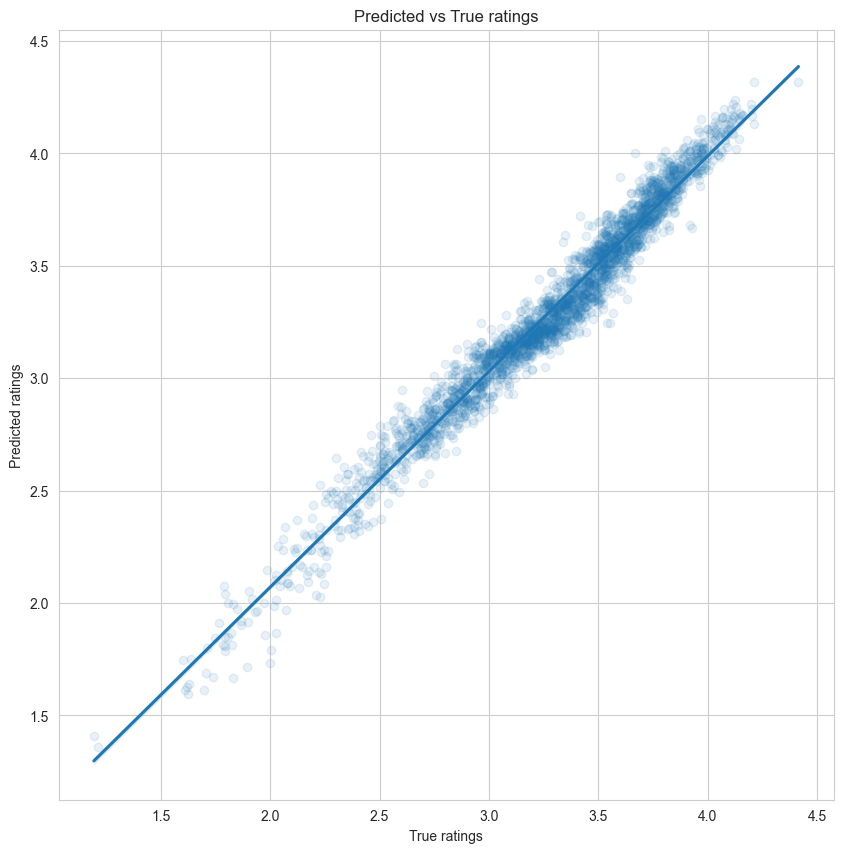

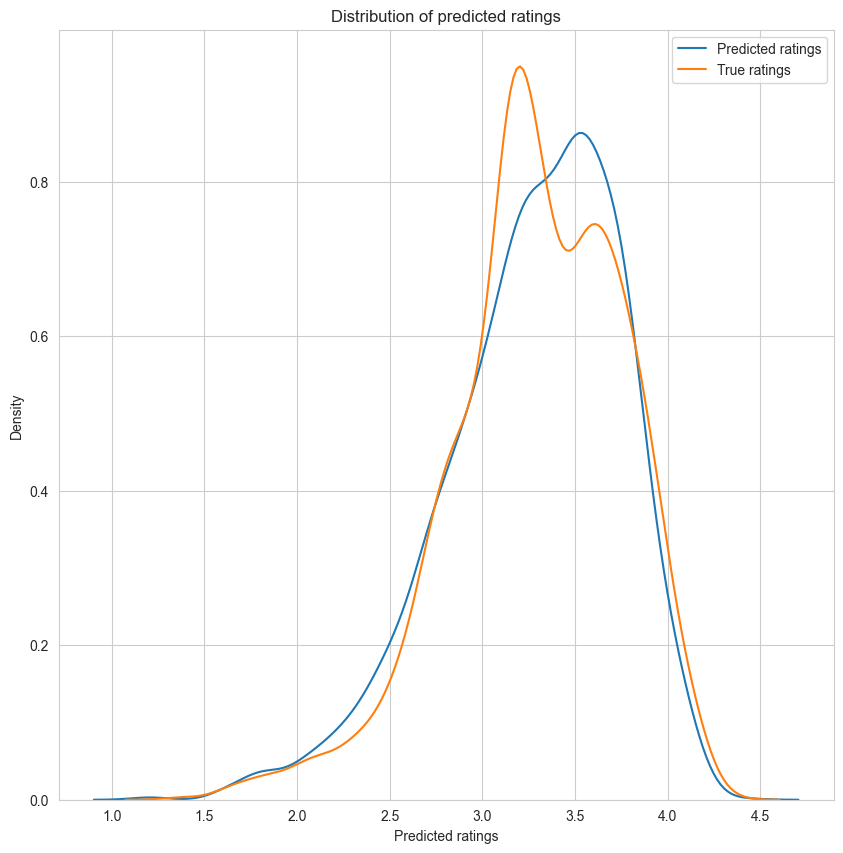

In [28]:
# Plotting the results
plt.figure(figsize=(10, 10))
sns.regplot(x=y_true, y=y_pred, scatter_kws={'alpha': 0.1}) ## alpha ???
plt.xlabel('True year')
plt.ylabel('Predicted year')
plt.title('Predicted vs True year')
plt.show()

# Distribution of predicted years
plt.figure(figsize=(10, 10))
y_pred = np.array(y_pred)
sns.kdeplot(y_true)
sns.kdeplot(y_pred.flatten())
plt.legend(['Predicted years', 'True years'])
plt.xlabel('Predicted years')
plt.title('Distribution of predicted years')
plt.show()